<a href="https://colab.research.google.com/github/RuHae/TGM_Project/blob/main/C_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import medmnist
from medmnist import INFO, Evaluator
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.utils.data as data
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [16]:
class Encoder(nn.Module):
    def __init__(self, feature_size, latent_dims, mode, channels, class_size):
        super(Encoder, self).__init__()
        self.channels = channels
        self.class_size = class_size
        self.feature_size = feature_size
        self.latent_dims = latent_dims
        self.mode = mode
        # image input 28*28*3
        # convolution layer 
        self.conv1 = nn.Conv2d(self.channels, 6, 3, stride=2)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=2)
        # linear layer
        self.fc1  = nn.Linear((12*6*6)+class_size, 128) # hard coded size after convolutions
        self.fc2  = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, self.latent_dims)
        self.fc22 = nn.Linear(128, self.latent_dims)
        # normalization 
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(12)
        # activation
        self.relu = nn.ReLU()

    def forward(self, x, c):
        nsamples = 100
        x = self.relu((self.conv1(x)))
        x = self.relu((self.conv2(x)))
        inputs = torch.cat([x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]), c], 1) # (bs, feature_size+class_size)
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

class Decoder(nn.Module):
    def __init__(self, feature_size, latent_dims, mode, channels, class_size):
        super(Decoder, self).__init__()
        self.channels = channels
        self.class_size = class_size
        self.feature_size = feature_size
        self.latent_dims = latent_dims
        # linear input layer
        self.fc3 = nn.Linear(self.latent_dims + self.class_size, 432)
        # reverse convolutions
        self.conv1 = nn.ConvTranspose2d(12,6,3, stride=2)
        self.conv2 = nn.ConvTranspose2d(6,3,3, stride=2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(3,self.channels,1, stride=1)
        # normalization
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(3)
        # activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, c):
        inputs = torch.cat([z, c], 1) # concatinating latent space and classes
        h3 = self.relu(self.fc3(inputs))
        h4 = h3.reshape(-1, 12, 6, 6) 
        h5 = self.relu(self.conv1(h4))
        h6 = self.relu(self.conv2(h5))
        h7 = self.sigmoid(self.conv3(h6))
        return h7.reshape((-1, self.channels, 28, 28))


class VariationalAutoencoder(nn.Module):
    def __init__(self, feature_size, latent_dims, mode, channels, class_size):
        super(VariationalAutoencoder, self).__init__()
        self.channels = channels
        self.feature_size = feature_size
        self.class_size = class_size
        self.mode = mode
        self.encoder = Encoder(self.feature_size, latent_dims, self.mode, self.channels, self.class_size)
        self.decoder = Decoder(self.feature_size, latent_dims, self.mode, self.channels, self.class_size)
    
    def forward(self, x, c):
        mu, logvar = self.encoder.forward(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decoder.forward(z, c), mu, logvar

    def one_hot(self,labels, class_size):
      targets = torch.zeros(labels.size(0), class_size)
      for i, label in enumerate(labels):
        targets[i, label] = 1
      return targets.to(device)
    
    # calculation of latent variable z
    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std
  
    # Reconstruction + KL divergence losses summed over all elements and batch
    def loss_function(self, recon_x, x, mu, logvar):
      BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      return BCE + KLD, BCE, KLD
    
    def train(self, data, epochs=5, lr=0.001, device="cpu"):
        # only for fast training
        opt = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            i = 0
            train_loss = 0
            for x, y in tqdm(data):
                x = x.to(device) # GPU
                y = self.one_hot(y, self.class_size)
                x_hat, mu, logvar = self.forward(x, y)
                opt.zero_grad()
                loss, bce, kld = self.loss_function(x_hat, x, mu, logvar)
                loss.backward()
                train_loss += loss.detach().cpu().numpy()
                opt.step()
                
            print("Iteration:", epoch, "Loss:", loss.item(), "KLD:", kld.item(), "BCE:", bce.item())

In [17]:
#data_flag = 'pathmnist'
data_flag = 'bloodmnist'
#data_flag = 'organamnist'
# data_flag = 'breastmnist'
#data_flag = 'octmnist'
# data_flag = 'chestmnist'
# data_flag = 'tissuemnist'
download = True

# hyper params
batch_size = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [18]:
latent_dims = 64
channels = 3
img_heigt = 28
img_width = 28
lr = 0.01
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # if no access to GPU 
vae = VariationalAutoencoder(img_heigt*img_width*channels, latent_dims, mode="conditional", channels=channels, class_size=n_classes).to(device)

vae.train(train_loader, lr=lr, epochs=epochs, device=device)

100%|██████████| 187/187 [00:08<00:00, 21.01it/s]


Iteration: 0 Loss: 68604.046875 KLD: 11.419771194458008 BCE: 68592.625


100%|██████████| 187/187 [00:07<00:00, 25.25it/s]


Iteration: 1 Loss: 69056.140625 KLD: 4.645124912261963 BCE: 69051.4921875


100%|██████████| 187/187 [00:07<00:00, 24.76it/s]


Iteration: 2 Loss: 68529.2109375 KLD: 2.921888828277588 BCE: 68526.2890625


100%|██████████| 187/187 [00:07<00:00, 24.71it/s]


Iteration: 3 Loss: 66395.96875 KLD: 2.1866912841796875 BCE: 66393.78125


100%|██████████| 187/187 [00:09<00:00, 19.23it/s]


Iteration: 4 Loss: 67451.203125 KLD: 1.7121281623840332 BCE: 67449.4921875


100%|██████████| 187/187 [00:07<00:00, 26.27it/s]


Iteration: 5 Loss: 69719.703125 KLD: 1.8725076913833618 BCE: 69717.828125


100%|██████████| 187/187 [00:06<00:00, 27.58it/s]


Iteration: 6 Loss: 67226.0390625 KLD: 1.0843555927276611 BCE: 67224.953125


100%|██████████| 187/187 [00:05<00:00, 33.00it/s]


Iteration: 7 Loss: 69789.875 KLD: 0.985480785369873 BCE: 69788.890625


100%|██████████| 187/187 [00:05<00:00, 31.95it/s]


Iteration: 8 Loss: 68840.4375 KLD: 1.1426091194152832 BCE: 68839.296875


100%|██████████| 187/187 [00:05<00:00, 36.08it/s]


Iteration: 9 Loss: 66733.2734375 KLD: 0.7584391832351685 BCE: 66732.515625


100%|██████████| 187/187 [00:05<00:00, 31.88it/s]


Iteration: 10 Loss: 68651.515625 KLD: 0.7802773714065552 BCE: 68650.734375


100%|██████████| 187/187 [00:06<00:00, 29.87it/s]


Iteration: 11 Loss: 67376.328125 KLD: 0.9979533553123474 BCE: 67375.328125


100%|██████████| 187/187 [00:05<00:00, 36.61it/s]


Iteration: 12 Loss: 69025.5625 KLD: 0.8950538635253906 BCE: 69024.6640625


100%|██████████| 187/187 [00:06<00:00, 27.18it/s]


Iteration: 13 Loss: 67886.6796875 KLD: 0.9642742276191711 BCE: 67885.71875


100%|██████████| 187/187 [00:06<00:00, 27.56it/s]


Iteration: 14 Loss: 67712.4296875 KLD: 0.7492486238479614 BCE: 67711.6796875


100%|██████████| 187/187 [00:05<00:00, 35.79it/s]


Iteration: 15 Loss: 69019.1015625 KLD: 0.7641302347183228 BCE: 69018.3359375


100%|██████████| 187/187 [00:05<00:00, 33.36it/s]


Iteration: 16 Loss: 68561.640625 KLD: 0.6396434307098389 BCE: 68561.0


100%|██████████| 187/187 [00:05<00:00, 35.60it/s]


Iteration: 17 Loss: 68808.90625 KLD: 0.8402382135391235 BCE: 68808.0625


100%|██████████| 187/187 [00:05<00:00, 36.09it/s]


Iteration: 18 Loss: 67679.6875 KLD: 0.9578030109405518 BCE: 67678.7265625


100%|██████████| 187/187 [00:05<00:00, 35.68it/s]


Iteration: 19 Loss: 68779.3203125 KLD: 0.6136270761489868 BCE: 68778.703125


100%|██████████| 187/187 [00:05<00:00, 35.22it/s]


Iteration: 20 Loss: 67874.9921875 KLD: 0.8420199155807495 BCE: 67874.1484375


100%|██████████| 187/187 [00:05<00:00, 35.30it/s]


Iteration: 21 Loss: 69399.6484375 KLD: 0.6324852705001831 BCE: 69399.015625


100%|██████████| 187/187 [00:05<00:00, 35.30it/s]


Iteration: 22 Loss: 69037.8203125 KLD: 0.6184970140457153 BCE: 69037.203125


100%|██████████| 187/187 [00:05<00:00, 36.10it/s]


Iteration: 23 Loss: 67136.828125 KLD: 0.7520613074302673 BCE: 67136.078125


100%|██████████| 187/187 [00:05<00:00, 36.05it/s]


Iteration: 24 Loss: 68125.1171875 KLD: 0.7675313949584961 BCE: 68124.3515625


100%|██████████| 187/187 [00:05<00:00, 35.94it/s]


Iteration: 25 Loss: 68226.0078125 KLD: 0.696666955947876 BCE: 68225.3125


100%|██████████| 187/187 [00:05<00:00, 35.49it/s]


Iteration: 26 Loss: 68420.421875 KLD: 0.7476339936256409 BCE: 68419.671875


100%|██████████| 187/187 [00:05<00:00, 36.17it/s]


Iteration: 27 Loss: 67877.359375 KLD: 0.6108815670013428 BCE: 67876.75


100%|██████████| 187/187 [00:05<00:00, 35.29it/s]


Iteration: 28 Loss: 68024.09375 KLD: 0.7203229069709778 BCE: 68023.375


100%|██████████| 187/187 [00:05<00:00, 35.82it/s]


Iteration: 29 Loss: 69131.2109375 KLD: 0.5468851327896118 BCE: 69130.6640625


100%|██████████| 187/187 [00:05<00:00, 35.92it/s]


Iteration: 30 Loss: 68898.2890625 KLD: 0.6776596307754517 BCE: 68897.609375


100%|██████████| 187/187 [00:05<00:00, 35.89it/s]


Iteration: 31 Loss: 68907.3046875 KLD: 0.6013238430023193 BCE: 68906.703125


100%|██████████| 187/187 [00:05<00:00, 36.37it/s]


Iteration: 32 Loss: 67989.21875 KLD: 0.7059575319290161 BCE: 67988.515625


100%|██████████| 187/187 [00:05<00:00, 36.20it/s]


Iteration: 33 Loss: 66929.7265625 KLD: 0.45775920152664185 BCE: 66929.265625


100%|██████████| 187/187 [00:05<00:00, 36.11it/s]


Iteration: 34 Loss: 69965.7734375 KLD: 0.4177825152873993 BCE: 69965.359375


100%|██████████| 187/187 [00:05<00:00, 36.11it/s]


Iteration: 35 Loss: 67708.109375 KLD: 0.4542072117328644 BCE: 67707.65625


100%|██████████| 187/187 [00:05<00:00, 35.87it/s]


Iteration: 36 Loss: 69337.9140625 KLD: 0.5711212754249573 BCE: 69337.34375


100%|██████████| 187/187 [00:05<00:00, 35.52it/s]


Iteration: 37 Loss: 67812.5 KLD: 0.6122666597366333 BCE: 67811.890625


100%|██████████| 187/187 [00:05<00:00, 35.94it/s]


Iteration: 38 Loss: 68062.671875 KLD: 0.6486127376556396 BCE: 68062.0234375


100%|██████████| 187/187 [00:05<00:00, 35.97it/s]


Iteration: 39 Loss: 66941.8671875 KLD: 0.7192459106445312 BCE: 66941.1484375


100%|██████████| 187/187 [00:05<00:00, 35.57it/s]


Iteration: 40 Loss: 68403.2890625 KLD: 0.47685831785202026 BCE: 68402.8125


100%|██████████| 187/187 [00:05<00:00, 35.76it/s]


Iteration: 41 Loss: 66706.671875 KLD: 0.5028745532035828 BCE: 66706.171875


100%|██████████| 187/187 [00:05<00:00, 36.11it/s]


Iteration: 42 Loss: 67838.0703125 KLD: 0.36142438650131226 BCE: 67837.7109375


100%|██████████| 187/187 [00:05<00:00, 36.12it/s]


Iteration: 43 Loss: 68831.5234375 KLD: 0.47302931547164917 BCE: 68831.046875


100%|██████████| 187/187 [00:05<00:00, 36.42it/s]


Iteration: 44 Loss: 69073.59375 KLD: 0.4693298041820526 BCE: 69073.125


100%|██████████| 187/187 [00:05<00:00, 36.21it/s]


Iteration: 45 Loss: 67481.59375 KLD: 0.46882331371307373 BCE: 67481.125


100%|██████████| 187/187 [00:05<00:00, 36.44it/s]


Iteration: 46 Loss: 68530.0703125 KLD: 0.4717704653739929 BCE: 68529.6015625


100%|██████████| 187/187 [00:05<00:00, 36.20it/s]


Iteration: 47 Loss: 68115.9765625 KLD: 0.5406269431114197 BCE: 68115.4375


100%|██████████| 187/187 [00:05<00:00, 35.98it/s]


Iteration: 48 Loss: 68607.765625 KLD: 0.5533924698829651 BCE: 68607.2109375


100%|██████████| 187/187 [00:05<00:00, 36.25it/s]


Iteration: 49 Loss: 69415.7265625 KLD: 0.48723891377449036 BCE: 69415.2421875


100%|██████████| 187/187 [00:05<00:00, 36.22it/s]


Iteration: 50 Loss: 66966.6953125 KLD: 0.5859750509262085 BCE: 66966.109375


100%|██████████| 187/187 [00:05<00:00, 36.08it/s]


Iteration: 51 Loss: 68374.1953125 KLD: 0.40019139647483826 BCE: 68373.796875


100%|██████████| 187/187 [00:05<00:00, 36.07it/s]


Iteration: 52 Loss: 68919.6328125 KLD: 0.4625995457172394 BCE: 68919.171875


100%|██████████| 187/187 [00:05<00:00, 35.91it/s]


Iteration: 53 Loss: 68233.34375 KLD: 0.5659924745559692 BCE: 68232.78125


100%|██████████| 187/187 [00:05<00:00, 36.01it/s]


Iteration: 54 Loss: 69217.15625 KLD: 0.5490225553512573 BCE: 69216.609375


100%|██████████| 187/187 [00:05<00:00, 35.95it/s]


Iteration: 55 Loss: 68784.328125 KLD: 0.3673006594181061 BCE: 68783.9609375


100%|██████████| 187/187 [00:05<00:00, 36.27it/s]


Iteration: 56 Loss: 68512.8515625 KLD: 0.5843080282211304 BCE: 68512.265625


100%|██████████| 187/187 [00:05<00:00, 35.96it/s]


Iteration: 57 Loss: 69899.8203125 KLD: 0.4447461664676666 BCE: 69899.375


100%|██████████| 187/187 [00:05<00:00, 36.26it/s]


Iteration: 58 Loss: 67671.09375 KLD: 0.39082542061805725 BCE: 67670.703125


100%|██████████| 187/187 [00:05<00:00, 35.51it/s]


Iteration: 59 Loss: 67406.71875 KLD: 0.391194224357605 BCE: 67406.328125


100%|██████████| 187/187 [00:05<00:00, 35.72it/s]


Iteration: 60 Loss: 66945.765625 KLD: 0.4338344931602478 BCE: 66945.328125


100%|██████████| 187/187 [00:05<00:00, 36.08it/s]


Iteration: 61 Loss: 68088.9140625 KLD: 0.48329025506973267 BCE: 68088.4296875


100%|██████████| 187/187 [00:05<00:00, 35.98it/s]


Iteration: 62 Loss: 69839.75 KLD: 0.45272544026374817 BCE: 69839.296875


100%|██████████| 187/187 [00:05<00:00, 36.07it/s]


Iteration: 63 Loss: 67623.015625 KLD: 0.42275726795196533 BCE: 67622.59375


100%|██████████| 187/187 [00:05<00:00, 35.86it/s]


Iteration: 64 Loss: 67179.0703125 KLD: 0.4916645586490631 BCE: 67178.578125


100%|██████████| 187/187 [00:05<00:00, 36.15it/s]


Iteration: 65 Loss: 69637.515625 KLD: 0.40148138999938965 BCE: 69637.1171875


100%|██████████| 187/187 [00:05<00:00, 35.77it/s]


Iteration: 66 Loss: 68119.9296875 KLD: 0.5702214241027832 BCE: 68119.359375


100%|██████████| 187/187 [00:05<00:00, 36.05it/s]


Iteration: 67 Loss: 68389.046875 KLD: 0.36561399698257446 BCE: 68388.6796875


100%|██████████| 187/187 [00:05<00:00, 35.61it/s]


Iteration: 68 Loss: 68250.84375 KLD: 0.4191233217716217 BCE: 68250.421875


100%|██████████| 187/187 [00:05<00:00, 35.87it/s]


Iteration: 69 Loss: 68925.0703125 KLD: 0.5999584197998047 BCE: 68924.46875


100%|██████████| 187/187 [00:05<00:00, 36.39it/s]


Iteration: 70 Loss: 68433.296875 KLD: 0.33784717321395874 BCE: 68432.9609375


100%|██████████| 187/187 [00:05<00:00, 35.67it/s]


Iteration: 71 Loss: 67717.234375 KLD: 0.4458574950695038 BCE: 67716.7890625


100%|██████████| 187/187 [00:05<00:00, 32.48it/s]


Iteration: 72 Loss: 67883.484375 KLD: 0.6067936420440674 BCE: 67882.875


100%|██████████| 187/187 [00:05<00:00, 36.17it/s]


Iteration: 73 Loss: 69477.4453125 KLD: 0.6201410293579102 BCE: 69476.828125


100%|██████████| 187/187 [00:05<00:00, 35.76it/s]


Iteration: 74 Loss: 66429.3984375 KLD: 0.5931577086448669 BCE: 66428.8046875


100%|██████████| 187/187 [00:05<00:00, 36.28it/s]


Iteration: 75 Loss: 68988.8359375 KLD: 0.5671759247779846 BCE: 68988.265625


100%|██████████| 187/187 [00:05<00:00, 35.76it/s]


Iteration: 76 Loss: 67926.0859375 KLD: 0.36811694502830505 BCE: 67925.71875


100%|██████████| 187/187 [00:05<00:00, 36.20it/s]


Iteration: 77 Loss: 67303.546875 KLD: 0.46794965863227844 BCE: 67303.078125


100%|██████████| 187/187 [00:05<00:00, 35.90it/s]


Iteration: 78 Loss: 69303.046875 KLD: 0.45074209570884705 BCE: 69302.59375


100%|██████████| 187/187 [00:05<00:00, 36.06it/s]


Iteration: 79 Loss: 66781.8359375 KLD: 0.41412562131881714 BCE: 66781.421875


100%|██████████| 187/187 [00:05<00:00, 35.54it/s]


Iteration: 80 Loss: 70356.484375 KLD: 0.3957149386405945 BCE: 70356.0859375


100%|██████████| 187/187 [00:05<00:00, 35.95it/s]


Iteration: 81 Loss: 69194.234375 KLD: 0.3571183979511261 BCE: 69193.875


100%|██████████| 187/187 [00:05<00:00, 35.49it/s]


Iteration: 82 Loss: 68809.03125 KLD: 0.48205599188804626 BCE: 68808.546875


100%|██████████| 187/187 [00:05<00:00, 35.32it/s]


Iteration: 83 Loss: 69003.1328125 KLD: 0.3557628393173218 BCE: 69002.7734375


100%|██████████| 187/187 [00:05<00:00, 35.42it/s]


Iteration: 84 Loss: 67549.5234375 KLD: 0.2958478033542633 BCE: 67549.2265625


100%|██████████| 187/187 [00:05<00:00, 35.66it/s]


Iteration: 85 Loss: 68779.671875 KLD: 0.6952557563781738 BCE: 68778.9765625


100%|██████████| 187/187 [00:05<00:00, 35.79it/s]


Iteration: 86 Loss: 65935.75 KLD: 0.5719146728515625 BCE: 65935.1796875


100%|██████████| 187/187 [00:05<00:00, 35.86it/s]


Iteration: 87 Loss: 69155.859375 KLD: 0.4379405081272125 BCE: 69155.421875


100%|██████████| 187/187 [00:05<00:00, 36.04it/s]


Iteration: 88 Loss: 69287.9140625 KLD: 0.4193364083766937 BCE: 69287.4921875


100%|██████████| 187/187 [00:05<00:00, 35.86it/s]


Iteration: 89 Loss: 68185.8125 KLD: 0.34551501274108887 BCE: 68185.46875


100%|██████████| 187/187 [00:05<00:00, 36.20it/s]


Iteration: 90 Loss: 67585.0625 KLD: 0.4936790466308594 BCE: 67584.5703125


100%|██████████| 187/187 [00:05<00:00, 35.99it/s]


Iteration: 91 Loss: 67678.28125 KLD: 0.38700297474861145 BCE: 67677.890625


100%|██████████| 187/187 [00:05<00:00, 36.16it/s]


Iteration: 92 Loss: 68167.53125 KLD: 0.41991502046585083 BCE: 68167.109375


100%|██████████| 187/187 [00:05<00:00, 36.02it/s]


Iteration: 93 Loss: 68369.328125 KLD: 0.373973548412323 BCE: 68368.953125


100%|██████████| 187/187 [00:05<00:00, 35.68it/s]


Iteration: 94 Loss: 66742.6796875 KLD: 0.38517042994499207 BCE: 66742.296875


100%|██████████| 187/187 [00:05<00:00, 35.82it/s]


Iteration: 95 Loss: 68475.9609375 KLD: 0.3101770579814911 BCE: 68475.6484375


100%|██████████| 187/187 [00:05<00:00, 35.85it/s]


Iteration: 96 Loss: 68434.0078125 KLD: 0.37755340337753296 BCE: 68433.6328125


100%|██████████| 187/187 [00:05<00:00, 35.69it/s]


Iteration: 97 Loss: 67721.4375 KLD: 0.3571052849292755 BCE: 67721.078125


100%|██████████| 187/187 [00:05<00:00, 36.12it/s]


Iteration: 98 Loss: 68751.703125 KLD: 0.3764928877353668 BCE: 68751.328125


100%|██████████| 187/187 [00:05<00:00, 35.85it/s]

Iteration: 99 Loss: 68773.328125 KLD: 0.3683726489543915 BCE: 68772.9609375


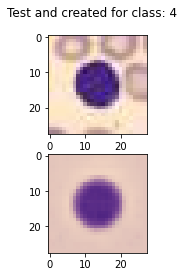

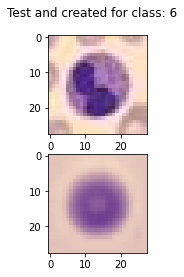

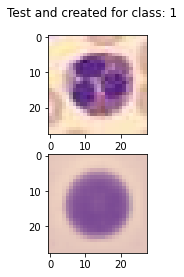

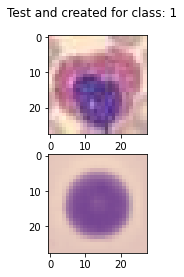

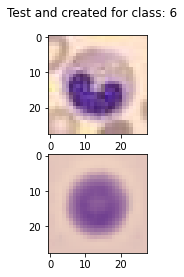

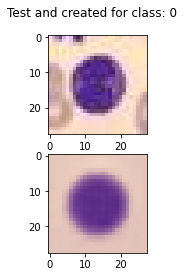

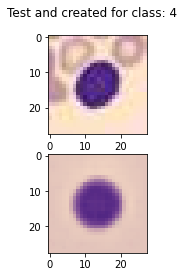

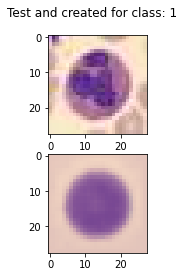

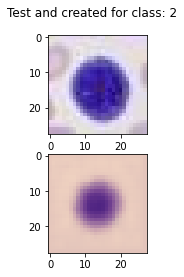

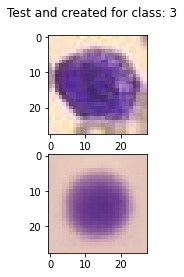

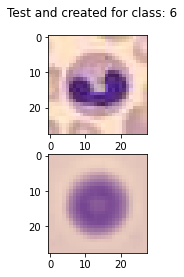

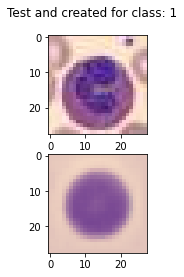

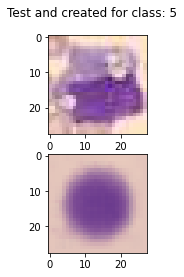

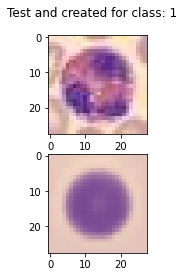

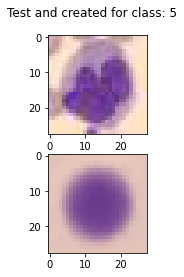

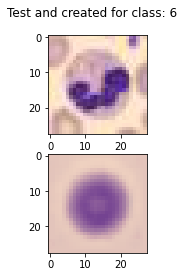

In [19]:
# print real and regenerated image with class
max_index = 3421 #blood=3421, path=7180, organAMNIST=17778
c_size = n_classes
for r in range(0,c_size*2):
  index = random.randint(0, max_index)
  test_img = test_dataset[index][0][None,:,:,:].to(device)
  test_c = test_dataset[index][1][None,:]
  c = torch.LongTensor(test_c).to(device)
  c = vae.one_hot(c,c_size)
  img, mu, log = vae.forward(test_img,c)
  fig, axs = plt.subplots(2)
  fig.suptitle('Test and created for class: ' + str(test_dataset[index][1][0]))
  if channels < 3:
   axs[0].imshow(test_img[0,0,:,:].moveaxis(0, 1).cpu().detach().numpy(), cmap="gray")
   axs[1].imshow(img[0,0,:,:].moveaxis(0, 1).cpu().detach().numpy(), cmap="gray")
  else:
    axs[0].imshow(test_img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
    axs[1].imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
  plt.plot()

The results from the CVAE are blurry and learn not the details, which were required for our task. According to the research from Bao et al. [1] this is a common issue and would be resolved by adding a GAN architecture.

[1] "CVAE-GAN: Fine-Grained Image Generation through Asymmetric Training", https://openaccess.thecvf.com/content_ICCV_2017/papers/Bao_CVAE-GAN_Fine-Grained_Image_ICCV_2017_paper.pdf 

In [20]:
def plot_latent(autoencoder, data, num_batches=64, class_size=1):
    for i, (x, y) in enumerate(data):
        labels = vae.one_hot(y,class_size)
        z_mu, z_var = autoencoder.encoder.forward(x.to(device), labels.to(device))
        z_mu = z_mu.to('cpu').detach().numpy()
        z_var = z_var.to('cpu').detach().numpy()
        N= torch.distributions.Normal(0, 1)
        z = z_mu + z_var* N.sample(z_mu.shape).detach().numpy()
        colors = y.to('cpu').detach().numpy()
        plt.scatter(z[:,0], z[:,1], c=colors[:,0], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

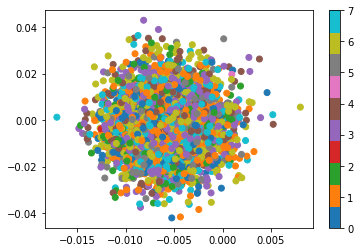

In [21]:
plot_latent(vae, train_loader, class_size=8)